# Relembrando

Voltemos ao problema multiobjetivo. Formalmente, temos

$
\displaystyle\min_{\boldsymbol{x} \in \mathbb{R}^D} \boldsymbol{f}(\mathbf{x}) = [f_1(\mathbf{x}),f_2(\mathbf{x}),\ldots,f_M(\mathbf{x})] \\
s.t. \\
g_j(\mathbf{x}) \leq 0, \; j = 1,2,\ldots,J \\
h_k(\mathbf{x}) = 0, \; k = 1,2,\ldots,K
$

onde $\mathbf{x} = (x_1,x_2,\ldots,x_D)^T$ é o vetor de variáveis de decisão.

A solução de problemas multiobjetivo depende do conceito de **dominância**. Diz-se que um vetor solução $\mathbf{x} = (x_1,\ldots,x_D)^T$ domina o vetor $\mathbf{x'} = (x'_1,\ldots,x'_D)^T$, se e somente se, $\mathbf{f(x)} \prec \mathbf{f(x')}$. Assim, para quaisquer dois vetores solução $\mathbb{x}$ e $\mathbb{x'}$ existem <u>três possibilidades</u>:

* $\mathbb{x}$ domina $\mathbb{x'}$; ou
* $\mathbb{x'}$ domina $\mathbb{x}$; ou
* $\mathbb{x}$ e $\mathbb{x'}$ não dominam um ao outro.

Uma solução viável $\mathbf{x^*}$ é chamada um <u>ótimo de Pareto</u> para um problema de otimização multiobjetivo se não existir um outro vetor solução viável que domine $\mathbf{x^*}$. Em outras palavras, **soluções ótimas são aquelas que não são dominadas por outras soluções**.

Diferentemente da otimização monoobjetivo, onde uma única solução ótima nos interessa, em problemas multiobjetivo a otimização nos leva um conjunto de soluções, chamada de **conjunto de ótimos de Pareto**, formado inteiramente por soluções não-dominadas. A imagem deste conjunto **no espaço de objetivo é chamada de fronteira de Pareto**.

Vimos que há três formas de reconstrução da fronteira de Pareto:
1. Método da função de utilidade monoobjetivo;
2. Método da $\epsilon$-restrição ($\epsilon$-*constraint*); e
3. Aproximação do conjunto Pareto-ótimo, por meio de metaheuristicas.

Vimos que os métodos 1 e 2 podem ser criticados por **gerar soluções que não cobrem bem a fronteira de Pareto** e **porque a fronteira obtida depende da formulação**. Portanto as metahuerísticas citadas no item 3 tem o papel de **encontrar um conjunto de soluções bem distribuídas sobre a fronteira de Pareto**, esta é uma preocupação fundamental como veremos à frente.

Há um grande número de metahuerísticas para problemas multiobjetivo e, em essência, **uma metaheurística percorre o espaço de solução avaliando as soluções em termos de sua dominância**. Aqui abordaremos o *Non-dominated Sorting Genetic Algorithm* (NSGA-II). Esta metaheurística é usada para problemas com dois objetivos e segue a ideia geral de um algoritmo genético. Por isso, começaremos apresentando o funcionamento dos <u>algoritmos genéticos</u>.

Para o estudo seremos apoiado pela biblioteca ```pymoo```.

## Preparação

In [ ]:
!pip install -q pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


A documentação da biblioteca ```pymoo``` está acessível em
https://pymoo.org/index.html

# Algoritmos Genéticos

## Ideia básica

Algoritmo Genético (AG) é uma metaheurística evolutiva inspirada no processo de seleção natural, no qual os indivíduos mais aptos sobrevivem e produzem filhos parecidos consigo, enquanto os menos aptos são eliminados com a passagem do tempo.

John Holland propôs os AGs em 1975 estabelecendo que uma **população** de soluções candidatas para um problema é gerada aleatoriamente. Os **indvíduos** (soluções) mais aptos (de acordo com uma função objetivo - *fitness function*) tem maior chance de produzir soluções similares a si após o **cruzamento**.

Em um problema binário, por exemplo, cada variável de decisão pode ser representada como um gene de um indivíduo (também chamado cromosssomo), como mostra a figura abaixo.

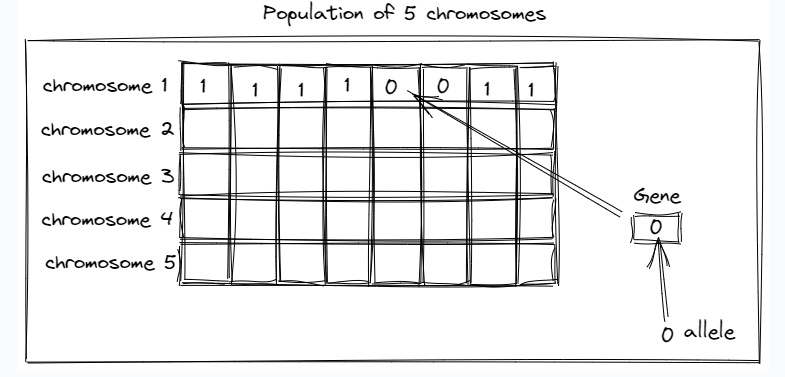

A **função de aptidão** (*fitness*) indica a qualidade de um cromossomo. Esta função leva em consideração a função objetivo do problema de otimização, mas pode considerar outros aspectos, principalmente em casos com restrições.

## Estrutura do AG

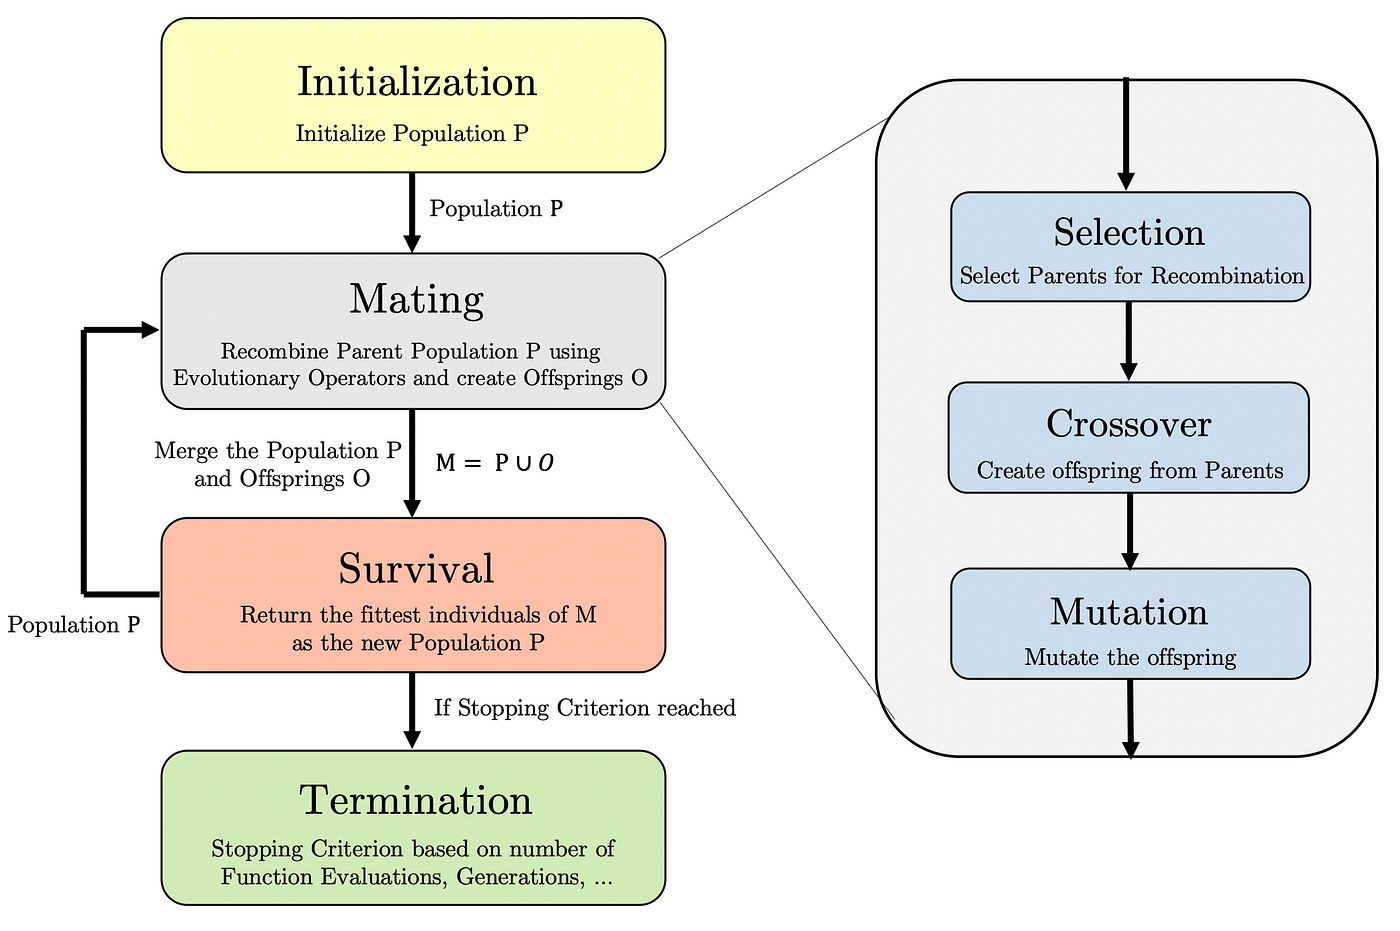

Figura retirada de: https://towardsdatascience.com/an-introduction-to-genetic-algorithms-the-concept-of-biological-evolution-in-optimization-fc96e78fa6db

Esta é uma estrutura geral, mas devemos definir diversos aspectos de cada uma destas etapas.

### O que devemos definir?

* **Representação da solução**: pode ser uma string binária, um vetor de inteiros, um vetor de pontos flutuantes, ou a permutação de uma lista. Ex: a solução do problema do caixeiro viajante é codificada como uma lista de vértices; a figura abaixo é um vetor de números reais.
* **Inicialização da população**: aleatoriamente definida. Ex: imagem abaixo mostra 5 cromossomos cujos alelos foram obtidos de uma distribuição uniforme contínua no intervalo -5 e 5.
* **Cálculo da aptidão**: cada cromossomo da população é passado à função de aptidão pra o cálculo da aptidão. Exemplo: a figura abaixo mostra o cálculo da aptidão para o problema $\min z = x_1^2 + x_2^2$


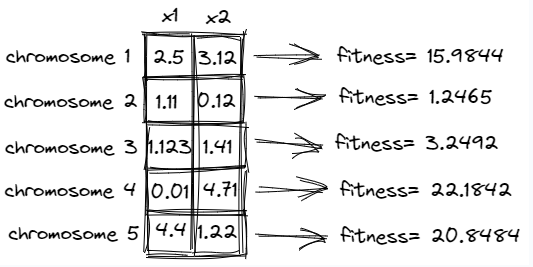

* **Casamento**: Em cada iteração o AG gera novas soluções a partir das existentes.
 * Inicia pela **seleção** dos cromossomos mais aptos para serem pais. Diversos métodos existem, os dois mais conhecidos:
    * elitista (*elitism*), os melhores são selecionados.
    * aleatório (*random*), sorteia-se um subconjunto com igual probabilidade;  
    * proporcional (*proportionate*) ou roleta, escolha aleatória com probabilidade proporcional à aptidão do cromossomo;
    * torneios (*tournament*): são realizados *n* sorteios (*n* é o tamanho da população na próxima etapa) de *k* cromossomos e escolhe-se o melhor deles (conforme a função de aptidão ou outro critério), comumente usamos *k=2* que é chamado de torneio binário.

 * Segue-se aplicando o operador de **cruzamento**, que vai usar os pais escolhidos para gerar uma prole, imitando a reprodução. Diversos métodos existem, três mais conhecidos:
    * um ponto, escolhe-se um único ponto de corte de forma aleatória (separando os genes em dois conjuntos contíguos) e produz-se dois filhos, de modo que cada um tenha um dos conjuntos de genes de cada pai;
    * multiponto, generaliza a idéia de troca de material genético através de pontos, onde muitos pontos de cruzamento podem ser utilizados;
    * e uniforme, cada gene é do pai 1, escolhido com probabilidade p, ou do pai 2, com probabilidade 1-p.

**Cruzamento de um ponto**

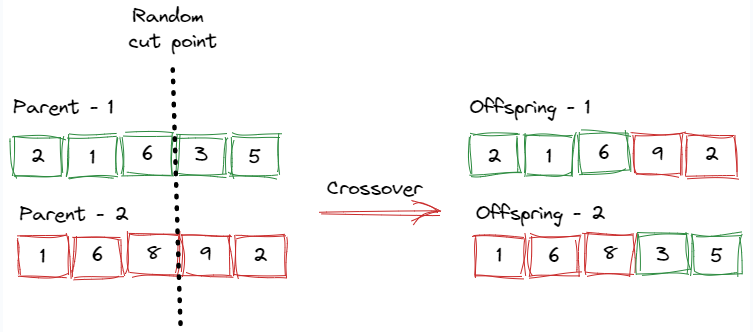

**Cruzamento Multiponto**

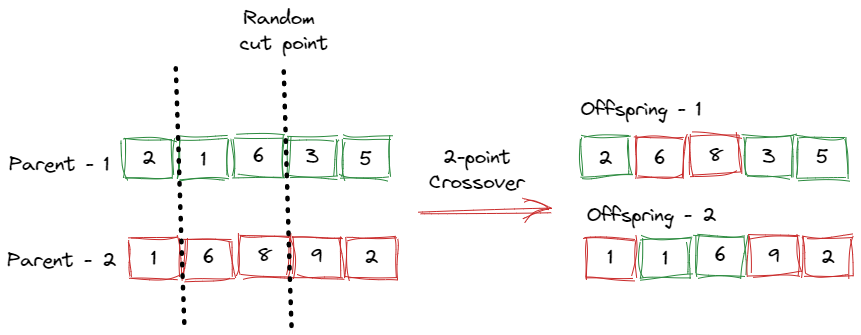

**Cruzamento Uniforme**

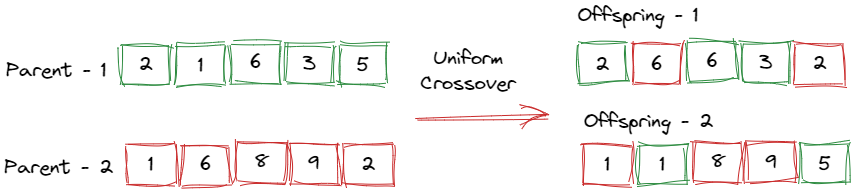

*
  * **Mutação**: imita a mutação humana, cada filho é modificado por uma mutação aleatória, introduzindo novas características nas soluções, o que permite melhor exploração do espaço de busca. Diversos métodos existem, três mais conhecidos:
   * troca de valor (*flip*), usado com variáveis binárias, um gene do cromossomo é modificado;
   * troca de posição (*swap*), usado com listas de permutações, troca-se os alelos de dois genes;
   * aleatório (*random*), usado em casos de vetores contínuos ou inteiros, troca-se o valor de um gene a partir de uma distribuição de probabilidade.

* **Sobrevivência**: dentre pais e filhos, escolhe-se o subconjunto de cromossomos que vão formar a população na próxima etapa. Comumente usa-se a aptidão e escolhe-se os melhores. Caso haja restrições no problema de otimização, pode-se usar a viabilidade como parâmetro de sobrevivência também.
 * agregação de pais e prole (*merging parents and new offspring*), descarta-se os que não foram escolhidos como pais no cruzamento.
* **Critério de Parada**: Diversos métodos existem e podem ser combinados, os três mais usados são:
 * um número prefefinido de iterações (gerações);
 * um valor de aptidão predefinido é obtido;
 * não há melhoria significativa nos resultados após um certo número de iterações.

## Parâmetros do AG

Alguns parâmetros influenciam bastante no comportamento do AG e de seu desempenho tanto em termos de qualidade da solução, quanto em termos de tempo de execução.

* **Tamanho da População**: uma população pequena pode fazer a qualidade da solução cair pois a população cobre poucos pontos do espaço de busca, já uma grande população aumenta a cobertura e evita a convergências prematura (ótimos locais), mas necessita de mais tempo e recursos computacionais.

* **Taxa de Cruzamento**: no cruzamento, após a etapa de seleção, pode-se gerar uma prole com genes exatamente iguais aos pais, sem cruzamento, assim a taxa de cruzamento indica a chance que a prole de uma dupla de cromossomos será criada por cruzamento. <u>Se alta, novas estruturas serão introduzidas na população mais rapidamente, mas bons indivíduos podem ser perdidos</u>. Se baixa, novas estruturas serão basicamente inseridas por mutação, e a convergência pode se tornar lenta.

* **Taxa de Mutação**: indica a chance de um cromossomo da prole ser escolhido para mudar. Se alta, a busca se torna essencialmente aleatória, se baixa demais a convergência fica mais lenta.

## AG - Exemplo 1

Construa um AG para encontrar solução para o problema abaixo

$\min z = x_1^2 + x_2^2$

Temos aqui um problema não-linear sem restrições. A função objetivo é dada pelo parabolóide abaixo, cujo mínimo é encontrado em $(x_1,x_2)=(0,0)$, com $z=0$. Vamos construir o AG e verificar se a solução é alcançada.

Exploraremos duas formas de construir o AG: implementando o algoritmo do zero; ou usando a biblioteca ```pymoo```.

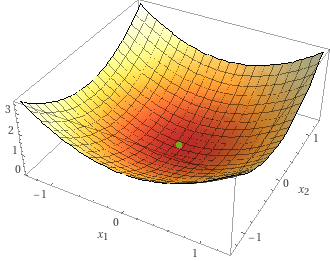

### Implementando do zero

Temos duas variáveis de decisão e, por isso, cada cromossomo terá 2 genes. Escolhemos uma quantidade de 10 cromossomos, formados por um vetor de números reais.

Cada gene pode assumir valores de -5 a 5. A escolha deste intervalo é arbitrária e deve ser feita com cuidado em cada caso, já que ela vai atuar limitando o espaço de busca. Caso este espaço não contenha o ótimo global, o AG não terá como encontrá-lo.

In [ ]:
genes = 2
cromossomos = 10
li = -5
ls = 5
dimensaoPop = (cromossomos, genes)
geracoes = 200
qtdeCromoCruzamento = 6
qtdeCromoProle = cromossomos - qtdeCromoCruzamento

txMutacao = 0.5
txCruzamento = 0.3

#### Inicialização da População

In [ ]:
import numpy as np

np.random.seed=1

def criaPop(li,ls,dimensao):
  pop = np.random.uniform(li, ls, dimensao)
  return pop

#### Função de aptidão

In [ ]:
def f(cromo):
  return np.sum(cromo*cromo) #calcula x1^2+x2^2

#### Cruzamento

Usamos o método de seleção dos k melhores

In [ ]:
def cruzamento(pop,qtdePais,qtdeProle,txCruz):
  """
    [Entradas]
    pop: população atual
    qtdePais: o número de cromossomos usados como pais
    qtdeProle: o número de cromossomos a ser gerados como prole
    txCruz: chance de haver um cruzamento entre dois cromossomos

    [Saídas]
    pais: conjunto de cromossomos escolhidos como pais
    prole: conjunto de cromossomos escolhidos como prole
  """

  #calcula aptidão de cada cromossomo
  aptidao = f(pop)
  #ordena os cromossomos segundo a aptidao. menores são mais aptos
  popOrdenada = sorted(pop, key = f)
  pais = np.vstack(popOrdenada[:qtdePais])
  #vetor para armazenar a prole
  prole = np.empty((qtdeProle, pop.shape[1]))

  for k in range(qtdeProle):
    # Index of the first parent
    pai1Index = k%pais.shape[0]
    # Index of the second.
    pai2Index = (k+1)%pais.shape[0]
    #Alguns cruzam, outros repetem o melhor
    if np.random.random() > txCruz:
      #Determining the crossover point
      ponto = np.random.randint(0,pop.shape[1])
      # Extracting first half of the offspring
      prole[k, 0: ponto] = pais[pai1Index, 0: ponto]
      # Extracting second half of the offspring
      prole[k, ponto:] = pais[pai2Index, ponto:]
    else:
      prole[k,] = pais[pai1Index]
  return pais,prole

#### Mutação

Vamos usar a mutação aleatória, porque os alelos são valores contínuos. De acordo com a taxa de mutação o gene é escolhido e um novo valor escolhido de uma distribuição uniforme entre -5 e 5.

In [ ]:
def mutacao(cromos,txMut,li,ls):
  for cromo in cromos:
    if np.random.random() < txMut:
      idx = np.random.randint(0,len(cromo))
      valor = np.random.uniform(li, ls, 1)
      cromo[idx] = valor

#### Sobrevivência

Vamos usar o método da agregação de pais e prole, descartando os piores.

In [ ]:
def sobrevivencia(pais,prole):
  return np.vstack([pais,prole])

#### AG

In [ ]:
populacao = criaPop(li,ls,dimensaoPop)

for i in range(geracoes):
  pais,prole = cruzamento(populacao,qtdeCromoCruzamento,qtdeCromoProle,txCruzamento)
  mutacao(prole,txMutacao,li,ls)
  populacao = sobrevivencia(pais,prole)

populacaoOrdenada = sorted(populacao, key = f)
for cromo in populacaoOrdenada:
  print(cromo,f(cromo))

[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[0.04030136 0.01069396] 0.0017385605834677595
[-3.31249735  0.01069396] 10.972753056403802


### Usando a biblioteca pymoo

Abaixo nós resolvemos o problema com a biblioteca ```pymoo```.

Começamos estabelecendo o problema na classe ```Exemplo``` que herda da classe ```Problem```. A biblioteca ```pymoo``` possui duas formas de implementar problemas. Neste caso estamos usando a classe ```Problem``` que assume uma implementação vetorizada em que as avaliações da aptidão será feita para toda a população no método ```_evaluate()```. Caso seja preferível, pode-se usar a classe ```ElementwiseProblem``` que implementa a avaliação de um indívudo por vez.

A escolha de uma ou outra forma de criação do problema terá impacto no tempo de execução. Enquanto ```ElementwiseProblem``` chama o método ```_evaluate()``` uma vez para cada indíviduo da população para o qual é preciso calcular a aptidão, o método ```_evaluate()``` da classe ```Problem``` recebe toda a população permitindo que o usuário tenha melhor performance ao operar com vetores.

Neste exemplo, optamos por usar a classe ```Problem``` já que temos uma função objetivo simples e podemos usar a biblioteca ```numpy``` para calcular a aptidão de toda uma população de forma vetorial.

No construtor da classe ```Exemplo``` indicamos que o problem tem duas variáveis de decisão (```n_var = genes``` e o número de genes foi configurado anteriormente), um objetivo (```n_obj = 1```) e que não possui restrições (```n_constr = 0```). Além disso, especificamos os limites inferior ```xl``` e superior ```xu``` de cada variável, sendo que os valores da lista são usados na ordem portanto, neste caso, temos que $-5 \leq x_1,x_2 \leq 5$ (os valores de ```li``` e ```ls``` foram configurados anteriormente).

A função ```_evaluate()``` implementa a avaliação da aptidão da população ```x```. Esta matriz contém os cromossomos de toda população, com cada coluna correspondendo a um dos genes do cromossomo (variáveis de decisão). O retorno desta função é dado pelo parâmetro ```out```. O que se espera é que este método ```_evaluate()``` vai preencher ```out["F"]``` com o valor da aptidão de cada cromossomo, na ordem em que aparecem em ```x```.

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.crossover.pntx import SinglePointCrossover
from pymoo.core.mutation import Mutation
import matplotlib.pyplot as plt

class Exemplo(Problem):
    def __init__(self):
        super().__init__(n_var=genes, n_obj=1, n_constr=0, xl=[li] * genes, xu=[ls] * genes)

    def _evaluate(self, x, out, *args, **kwargs):
        x1v = x[:,0]
        x2v = x[:,1]
        f1 = np.power(x1v,2) + np.power(x2v,2)
        out["F"] = f1

problem = Exemplo()

Abaixo vamos executar o AG com parâmetros iguais ao que fizemos do zero. Para isso temos de implementar a classe ```UniformMutation``` como um operador de mutação que usa a mutação aleatória seguindo uma distribuição uniforme.

Em seguida criamos um objeto da classe ```GA``` com uma população cujo tamanho é dado pela variável ```cromossomos```. O operador de cruzamento é modificado para ```SinglePointCrossover``` e o operador de mutação é modificado para ```UniformMutation```. Como operadores de seleção e de sobrevivência, usa-se o padrão, respectivamente, um torneio binário com base na aptidão e a sobrevivência com base na aptidão. A variável ```n_offsprings``` indica o tamanho da prole a cada geração e a opção ```eliminate_duplicates``` configurada como ```False``` evita que soluções iguais sejam removidas da população.



In [ ]:
class UniformMutation(Mutation):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _do(self, problem, X, **kwargs):
        X = X.astype(float)
        Xp = np.full(X.shape, np.inf)
        Xp[:, :] = X

        mut = np.random.random(X.shape[0]) < self.prob.get()
        idx = np.random.randint(0,X.shape[1],X.shape[0])[mut]
        val = np.random.uniform(problem.xl, problem.xu, X.shape)

        Xp[mut,idx] = val[mut,idx]

        return Xp

algorithm = GA(pop_size=cromossomos,
               #seleção é feita em um torneio binario
               crossover=SinglePointCrossover(prob=txCruzamento),
               mutation=UniformMutation(prob=txMutacao),
               #sobrevivência é feita pela aptidão
               n_offsprings = qtdeCromoProle,
               eliminate_duplicates=False)

Finalmente a função ```minimize``` executa o AG por um número definido de gerações. O parâmetro ```save_history``` exige que sejam armazenadas informações de cada uma das gerações.


In [ ]:
res = minimize(problem,
               algorithm,
               ('n_gen', geracoes),
               save_history=True,
               seed=1)

print("Rodando com parâmetros iguais ao que fizemos do zero")
print("Melhor solução: \nX = %s\nF = %s" % (res.X, res.F))

Rodando com parâmetros iguais ao que fizemos do zero
Melhor solução: 
X = [-0.00067629  0.01562805]
F = [0.00024469]


O código abaixo mostra os gráficos de convergência com o valor de aptidão da melhor solução ao longo das gerações.

Como se pode ver, após 50 iterações o algoritmo encontra sua melhor solução e permanece com ela até o fim da execução do algoritmo, sem alterações.

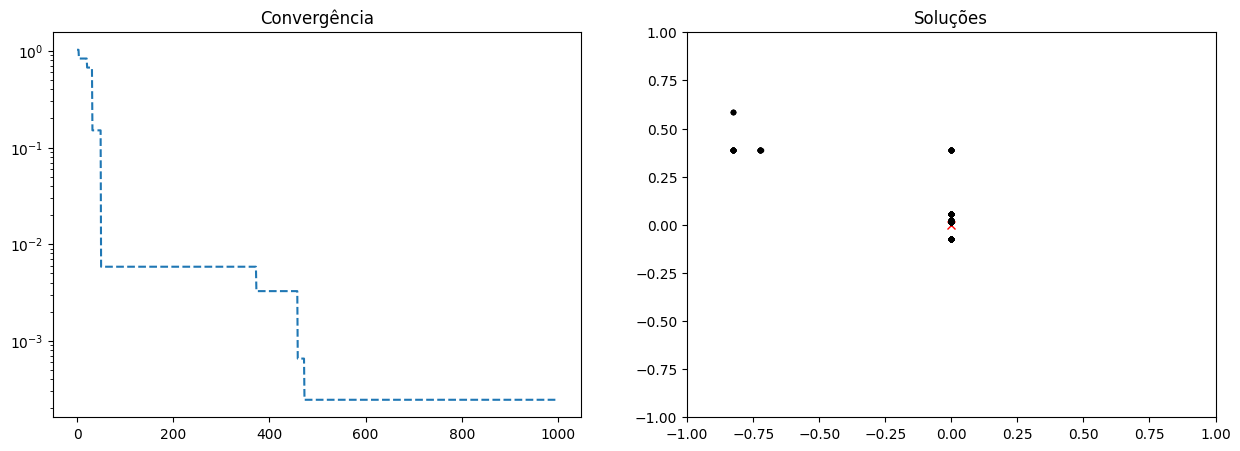

In [ ]:
#Convergência
opt = np.array([e.opt[0].F for e in res.history])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Convergência")
plt.plot(opt, "--")
plt.yscale("log")

sol = np.array([e.opt[0].X for e in res.history])

plt.subplot(1,2,2)
plt.title("Soluções")
plt.plot(0,0, "x", color="red")
plt.plot(sol[:,0],sol[:,1], ".", color="black")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

Abaixo nós executamos o AG com parâmetros padrão do algoritmo. A seleção é um torneio binário e a sobrevivência é feita pela aptidão. Contudo, o cruzamento usa o método SBX e a mutação uma estratégia polinomial. Mais sobre estas técnicas é visto à frente.

In [ ]:
algorithm = GA(pop_size=cromossomos,
               #seleção é feita em um torneio binario
               #cruzamento SBX
               #mutação Polinomial
               #sobrevivência é feita pela aptidão
               eliminate_duplicates=False)

res = minimize(problem,
               algorithm,
               ('n_gen', geracoes),
               save_history=True,
               seed=1)
print("Rodando com parâmetros padrão do método")
print("Melhor solução: \nX = %s\nF = %s" % (res.X, res.F))

Rodando com parâmetros padrão do método
Melhor solução: 
X = [-2.99656947e-04 -5.21593315e-05]
F = [9.25148818e-08]


A convergência do algoritmo é ilustrada novamente. Como se pode ver, com as mesmas 200 gerações pôde-se obter um resultado melhor.

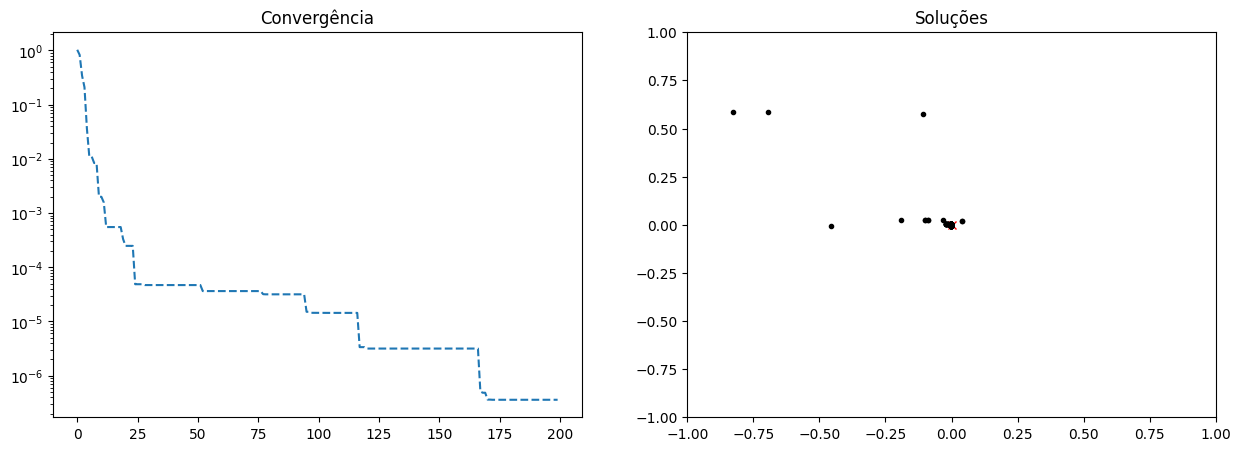

In [ ]:
#Convergência
opt = np.array([e.opt[0].F for e in res.history])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Convergência")
plt.plot(opt, "--")
plt.yscale("log")

sol = np.array([e.opt[0].X for e in res.history])

plt.subplot(1,2,2)
plt.title("Soluções")
plt.plot(0,0, "x", color="red")
plt.plot(sol[:,0],sol[:,1], ".", color="black")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

## Cruzamento SBX (Simulated Binary Crossover)

Cruzamento para variáveis contínuas que realiza o cruzamento, <u>não no cromossomo, mas em cada gene</u>, i.e., para cada variável contínua. Este cruzamento foi construído para garantir um **poder de busca** similar ao obtido pelo cruzamento de um ponto em vetores exclusivamente binários.

O **poder de busca** de um operador de cruzamento é a probabilidade deste criar um ponto arbitrário (prole) no espaço de busca dado dois pais. Um operador de cruzamento é um processo estocástico, o que significa que sua saída é aleatória, contudo um bom operador deveria ser capaz de gerar uma prole diversa dos pais com alguma probabilidade.

Dados dois pais ($p_1$ e $p_2$) e dois filhos ($c_1$ e $c_2$), o fator de espalhamento mede o quanto os filhos diferem entre si em comparação a diferença entre seus pais

$\beta = |\frac{c_2 - c_1}{p_2 - p_1}|$

Abaixo vemos a interpretação deste valor.

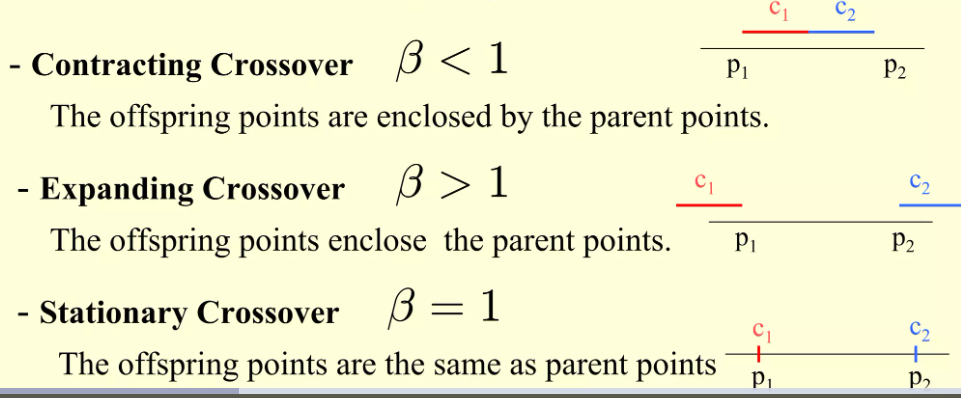

Observe então que dada a diferença entre os pais e um certo $\hat{\beta}$, pode-se estimar a diferença entre $c_1$ e $c_2$. Se assumirmos que os filhos serão dados pela média de seus pais ($\bar{x}$) mais esta diferença poderemos determinar o valor de $c_1$ e $c_2$ desta forma

$c_1 = \bar{x} - \frac{\hat{\beta}(p_2 - p_1)}{2} \\
c_2 = \bar{x} + \frac{\hat{\beta}(p_2 - p_1)}{2}$

**Mas como podemos escolher $\beta$?**

(DEB, K. & AGRAWAL, 1995) demonstram que em uma operação de cruzamento de um ponto binária, a função de densidade de $\beta$ é dada por

$f(\beta) = \begin{cases}
0.5(\eta_c+1)\beta^{\eta_c} & \text{se} \, \beta \leq 1\\
0.5(\eta_c+1)\frac{1}{\beta^{{\eta_c+2}}} & \text{se} \, \beta \gt 1
\end{cases}$

Que é representada graficamente abaixo.

Logo, para cada cruzamento que tenhamos que fazer, podemos obter $\beta$ **aleatoriamente via simulação**. Para tanto, geramos $U \sim \text{Unif}(0,1)$ e calculamos o valor de $beta$ usando a inversa da função de distribuição acumulada (como qualquer outra variável aleatória).

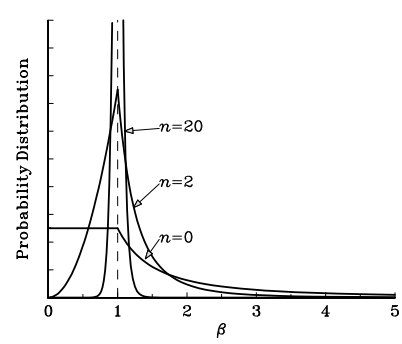

Como explicam (DEB, K.; SINDHYA, K.; OKABE, T., 2007), um ponto importante do operador SBX é que nas gerações iniciais, onde as soluções ainda estão sob o efeito da geração aleatória, <u>as diferenças entre dois pais escolhidos aleatoriamente no torneio será grande, o que vai levar a uma prole também apartada de seus pais</u>, **o que amplia o espaço de busca**. Entretanto, quando as gerações avançam e <u>as soluções tendem a convergir (a diferença entre os pais diminui), a prole deve também ficar não muito distante</u>, **focando a busca em uma região menor**.


O parâmetro $\eta_c$ é usado para controlar a forma da distribuição de $\beta$. Quanto maior o valor de $\eta_c$, maior a chance de termos valores de $\beta$ próximos de 1. O experimento abaixo ilustra essa ideia. São usados como pais apenas dois indívudos com uma única variável contínua e com valor fixo em 0.2 e 0.8. Estes pais são repetidos em uma população de 1000 pares de indivíduos e cada par é usado para gerar uma prole de dois indivíduos.

O experimento é repetido para dois valores de $\eta_c$: 2 e 10. Como se pode ver, o aumento de $\eta_c$ diminui a variabilidade em torno dos pais.

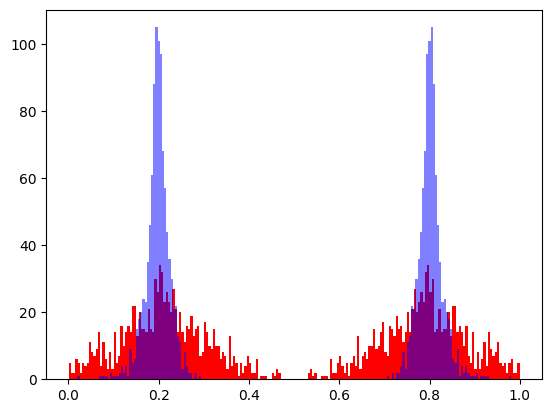

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pymoo.core.individual import Individual
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.repair.rounding import RoundingRepair


def show(eta_cross, clr="red", al=1.0):
    problem = Problem(n_var=1, xl=0.0, xu=1.0)

    a, b = Individual(X=np.array([0.2])), Individual(X=np.array([0.8]))

    parents = [[a, b] for _ in range(1000)]

    off = SBX(prob=1.0, prob_var=1.0, eta=eta_cross).do(problem, parents)

    Xp = off.get("X")

    plt.hist(Xp, bins=200, color=clr, alpha=al)


show(2)
show(15,"blue",0.5)
plt.show()

## Mutação polinomial

A mutação polinomial é uma <u>mutação atelatória</u> apresentada por (DEB, K.; SINDHYA, K.; OKABE, T., 2007). A base desta mutação é a estratégia usada no SBX. A ideia geral deste operador é que a o valor da variável mutada mantenha-se próximo ao valor original, ou seja, a probabilidade de pequenas mutações é maior do que a probabilidade de grandes mutações.

Assim como o SBX, a mutação polinomial é governada por um parâmetro $\eta$ cujo impacto é mostrado n exemplo abaixo.

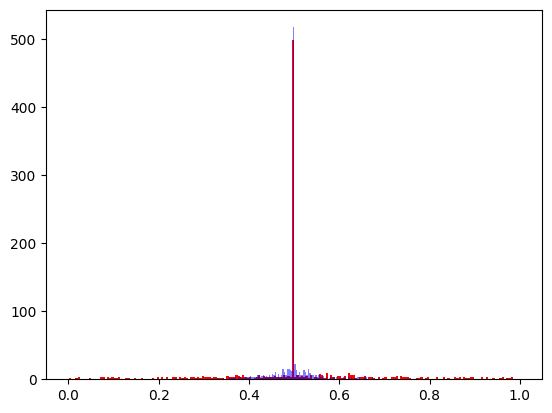

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pymoo.core.population import Population
from pymoo.core.problem import Problem
from pymoo.operators.mutation.pm import PolynomialMutation


def show(eta_mut, clr="red", al=1.0):
    problem = Problem(n_var=1, xl=0.0, xu=1.0)

    X = np.full((1000, 1), 0.5)
    pop = Population.new(X=X)

    mutation = PolynomialMutation(prob=1.0, eta=eta_mut)

    off = mutation(problem, pop)
    Xp = off.get("X")

    plt.hist(Xp, bins=200, color=clr, alpha=al)

show(2)
show(15,"blue",al=0.5)
plt.show()

## AG - Exemplo 2 - Problema da Mochila

Você vai almoçar e você sabe o valor de preferência dos diferentes alimentos (ex: você gosta mais de maçãs do que donuts), mas você possui um limite de calorias a consumir (ex: você não quer comer mais de 800 kcal). Escolher o que comer é um problema da mochila. Assuma um limite de 1000 calorias.

|Comida|	Utilidade|	Caloria|
|---|---|---|
|Vinho|	89|	123|
|Cerveja|	90|	154|
|Pizza|	30|	258|
|Sanduíche|	50|	454|
|Fritas|	90|	565|
|Coca|	79|	150|
|Maçã|	90|	95|
|Donut|	10|	195|

$u_j$ = é a utilidade da comida

$p_j$ = é a caloria da comida

$C_{max}$ = lmite de calorias

$x_j$ = variável binária que assume 1 se o comida é escolhida e 0 em outro caso

$\max \sum_j u_j x_j \\
s.t.\\
\sum_j p_jx_j \leq C_{max} \\
x_j \in \{0,1\}$

**Solução**

De aulas anteriores, nós já sabemos que a Utilidade máxima obtida neste problema é de 398.0. E que os itens escolhidos são: <u>Vinho, Cerveja, Sanduíche, Coca, Maçã</u>. A soma das calorias destes itens é de 976.0.

Abaixo iniciamos organizando nossos dados em um dicionário e, a partir dele, obtemos listas de utilidade e calorias, bem como o limite de calorias ```cmax```.

In [ ]:
import numpy as np

objetos = {
    "Vinho":[89,123],
    "Cerveja":[90,154],
    "Pizza": [30,258],
    "Sanduíche":	[50,454],
    "Fritas":	[90,565],
    "Coca":	[79,150],
    "Maçã":	[90,95],
    "Donut": [10,195]
}

nomes = objetos.keys()
valores = objetos.values()
utilidade = np.array(list(zip(*list(valores)))[0])
calorias = np.array(list(zip(*list(valores)))[1])

cmax = 1000

O problema é definido como uma classe que herda da classe ```Problem```. E os dados do problema são usados para definir atributos ```W``` (as calorias), ```P``` (a utilidade) e ```C``` (o limite de calorias), conforme a formulação do problema.

O método ```_evaluate()``` calcula o valor da função objetivo e da restrição para cada um dos elementos da população. Deve-se observar que a aptidão é calculada como $- \sum_i P_ix_i$ já que a biblioteca implementa os métodos assumindo problemas de minimização.

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import BGA #voltado para problemas binários
from pymoo.optimize import minimize
from pymoo.operators.crossover.pntx import SinglePointCrossover
from pymoo.core.mutation import Mutation
import matplotlib.pyplot as plt

class Mochila(Problem):
    def __init__(self,
                 n_items,  # number of items that can be picked up
                 W,  # weights for each item
                 P,  # profit of each item
                 C,  # maximum capacity
                 ):
        super().__init__(n_var=n_items, n_obj=1, n_ieq_constr=1, xl=0, xu=1, vtype=bool)

        self.W = W
        self.P = P
        self.C = C

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = -np.sum(self.P * x, axis=1)
        out["G"] = np.sum(self.W * x, axis=1) - self.C

problem = Mochila(n_items=len(objetos), W = calorias, P = utilidade, C = cmax)

algorithm = BGA(pop_size=10,
               # cruzamento de um ponto
               # seleção por torneio binário com aptidão baseada na "viabilidade primeiro"
               # Mutação é do tipo troca de valor (flip)
               # sobrevivência com aptidão baseada na "viabilidade primeiro"
               eliminate_duplicates=False)

res = minimize(problem,
               algorithm,
               ('n_gen', 4),
               save_history=True,
               seed=1)

i = 0
solucao = []
for nome in nomes:
  if res.X[i]:
    solucao += [nome]
  i += 1
print("Solução:",solucao)
print("Utilidade = %s\nPeso = %s" % (-res.F, cmax+res.G))

Solução: ['Vinho', 'Cerveja', 'Sanduíche', 'Coca', 'Maçã']
Utilidade = [398.]
Peso = [976.]


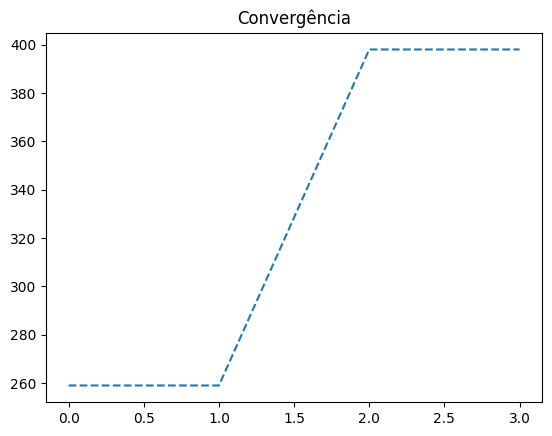

In [ ]:
#Convergência
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergência")
plt.plot(-opt, "--")

plt.show()

**Como o AG está tratando a restrição?**

Existem diferentes formas de inserir restrições em algoritmos de otimização. O método padrão adotado pela biblioteca ```pymoo``` é considerar a checagem da <u>viabilidade primeiro</u>, conforme descrito em (DOBNIKAR et al, 1999). Assim a equação de aptidão é dada por

$F(\mathbf{x}) = \begin{cases}
f(\mathbf{x}) & \text{if } g_j(\mathbf{x}) \geq 0, \forall j \in J \\
f_{max} + \sum_{j=1}^J \langle g_j(\mathbf{x}) \rangle & \text{outros casos}
\end{cases}$

onde $f_{max}$ é o máximo valor que a função $f(.)$ assume considerando apenas as soluções viáveis na população; e $\langle . \rangle$ é uma operação que devolve o valor absoluto do operando se o operando for negativo e retorna zero em qualquer outro caso.

Uma vantagem deste método é que ele evita que tenhamos que calcular a função de aptidão nos casos em que as restrições não são atendidas.

Mais sobre tratamento de restrições na biblioteca pode ser visto em https://pymoo.org/constraints/index.html?highlight=constraint%20violation

# NSGA-II

O NSGA-II (DEB et al., 2002) é um AG voltado à problemas de otimização multiobjetivo e é considerado um dos mais poderosos algoritmos evolucionários multiobjetivo. Para lidar com este tipo de problema, pode-se dizer de forma resumida que o NSGA-II modifica a forma como os cruzamentos são feitos e os melhores candidatos são escolhidos.

O NSGA-II é baseado no *Nondominated Sorting Genetic Algorithm* (NSGA) desenvolvido por (SRINIVAS; DEB, 1994). A ideia básica do NSGA é, partindo de uma população de soluções, explorar o espaço de busca escolhendo as soluções pela sua dominância, movendo-se em direção da fronteira de Pareto. As principais críticas a este algoritmo são: a **alta complexidade computacional da busca por soluções não-dominantes** e a **necessidade do ajuste de um hiperparâmetro para determinar quando duas soluções são consideradas próximas**.

Para lidar com estes problemas, o NSGA-II adiciona três mecanismos novos:

* Um procedimento eficiente (i.e., polinomial) de ordenação não-dominada (*non-dominated sorting*)
* Um procedimento eficiente de estimação do isolamento (*crowded distance*) de uma solução
* Um operador de comparação que estende a dominância clássica usando o conceito de isolamento



## Ordenação não-dominada

A base do NSGA de 1994 e do NSGA-II é o conceito de ordenação não-dominada, o qual fora originalmente proposto por Goldberg e Holland (1988). A ordernação não-dominada parte do pressuposto de que as soluções podem ser organizadas em diferentes fronteiras, de tal forma que as soluções dentro de uma fronteira são não-dominantes entre si.

A figura abaixo ilustra esta ideia. Nela, vemos as soluções (em verde) destacadas como nível 1 (*level 1*). Estas são as soluções da fronteira de Pareto e, portanto, são as soluções não-dominadas. Contudo, se relaxarmos o conceito de dominância, pode-se dizer que as soluções do nível 2 (em azul), embora sejam dominadas pelo nível 1, formam uma nova fronteira de soluções que também não se dominam entre si, mas que dominam as soluções do nível 3 (em rosa), por exemplo. Pode-se dizer que as soluções do nível 1 tem uma dominância "mais forte" do que o nível 2, que, por sua vez, é mais forte que o nível 3. Observe que esta versão de dominância mais relaxada pode ser aplicada indefinidamente, criando-se sucessivos níveis com dominância ainda mais fraca.

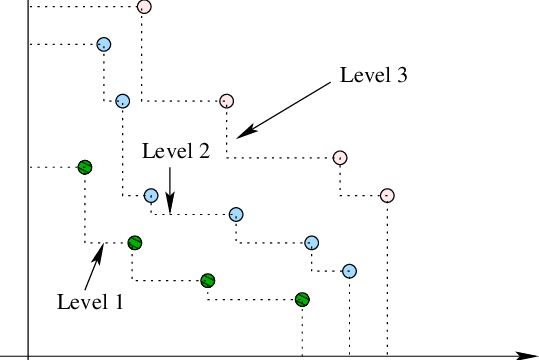

A principal ideia da ordenação não-dominada é organizar as soluções nas múltiplas fronteiras de dominância, de modo a poder explorar tanto o elitismo (escolha dos melhores) quanto a diversidade (escolha de soluções não tão boas, para melhorar a exploração do espaço de busca).

Essencialmente, o procedimento de ordenação não-dominada no NSGA de 1994 consiste em comparar as soluções entre si para determinar as soluções no primeiro nível de não-dominância. Em seguida, estas são temporariamente removidas, e uma nova comparação é feita. Nesta segunda rodada de comparação, as soluções não-dominadas formam a segunda fronteira. Estas, por sua vez, são removidas e uma terceira rodada de comparação se segue para determinar o nível 3. O procedimento segue até que todas as soluções estejam em alguma fronteira.

Como se pode observar este é um procedimento custoso, cuja complexidade é $O(MN^3)$, onde $M$ é o número de funções objetivo e $N$ é o tamanho da população. O algoritmo NSGA-II modifica esta estratégia e reduz a complexidade para $O(MN^2)$, armazenando informações de dominância obtidas na primeira iteração do algoritmo para determinar a primeira fronteira. Detalhes de implementação deste método eficiente de ordenação não-dominada podem ser encontrados em (DEB et al., 2002).

## Estimativa de isolamento

Para <u>manter a diversidade na população é importante que o AG use uma medida de distância entre as soluções</u> do problema multiobjetivo. O algoritmo NSGA de 1994 emprega uma estratégia que computa a distância entre duas soluções, mas que depende de um hiperparâmetro que determina até que ponto duas soluções podem ser ditas próximas.

Um outro aspecto importante é que a o algoritmo de solução do problema multiobjetivo <u>deve obter uma boa cobertura da fronteira de Pareto</u>.

Para obter uma boa cobertura e, ao mesmo tempo, simplificar o processo de comparação de distâncias, o algoritmo NSGA-II procura atender estes critérios propondo a medida de <u>**isolamento**, que estima a densidade de pontos em torno de uma solução, na fronteira a qual a solução pertence</u>.

Para determinar o isolamento de uma solução $i$, usa-se as posições das soluções $i-1$ e $i+1$ em sua própria fronteira. A partir das posições calcula-se a distância de Manhattan entre estas duas soluções, como mostrado abaixo.

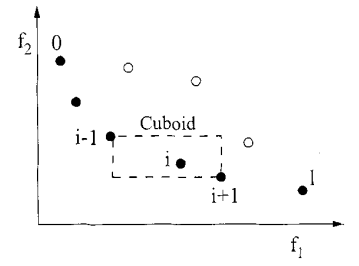

Esta medida consegue atender os critérios porque:

1.   Não possui nenhum hiperparâmetro a ser configurado;
2.   Não precisa comparar os indivíduos entre si; e
3.   quanto mais distante uma solução estiver de seu antecessor e sucessor na fronteira, maior será a medida de isolamento, e portanto, mais relevante será aquela solução para manter uma cobertura uniforme de sua fronteira.


## Operador de dominância ciente da aglomeração

Além de olhar para a dominância clássica entre as soluções, o NSGA-II incorpora a medida de isolamento no operador de comparação entre soluções.

Assumindo que cada indivíduo $i$ na população tem dois atributos: $i_{\text{rank}}$ e $i_{\text{isolation}}$ os quais indicam, respectivamente, a fronteira de dominância onde o indivíduo se encontra e a aglomeração do indíviduo. Assim, **o operador de dominância ciente da aglomeração** ($\prec_n$) (*crowded-comparison operator*) é definido como:

$i \prec_n j \iff (i_{\text{rank}} \lt j_{\text{rank}}) \; \text{or} \; (i_{\text{rank}} = j_{\text{rank}} \; \text{and} \; i_{\text{isolation}} \gt j_{\text{isolation}} ) $

Assim, entre duas soluções em diferentes fronteiras, nós preferimos aquela que está na fronteira de menor nível. Caso ambas as soluções pertençam a mesma fronteira, nós preferimos aquelas que estejam em uma região da fronteira menos aglomerada.

## Algoritmo

O primeiro passo do NSGA-II é gerar uma população aleatória $P_0$ de tamanho $N$ de soluções candidatas. Desta população, aplicando-se os operadores de cruzamento, mutação e seleção, gera-se a prole $Q_0$. Para esta primeira prole pode-se usar quaisquer operadores de cruzamento e mutação e é comum o uso do operador de torneio binário na seleção com base na função de aptidão como critério na seleção.

Após esta inicialização, o NSGA-II segue o procedimento abaixo:

> Enquanto $t <n_{gen}$ faça: \\
>> $R_t = P_t \cup Q_t$ \\
>> $F = \text{ordenação-não-dominada}(R_t)$ \\
>> $P_{t+1} = \varnothing$ \\
>> $i = 1$ \\
>> $\text{Enquanto} \; |P_{t+1}| + |F_i| \leq N \; \text{faça:}$ \\
>> $\;\;\; \text{calcula-isolamento}(F_i)$ \\
>> $\;\;\; P_{t+1} = P_{t+1} \cup F_i$ \\
>> $\;\;\; i = i+1$ \\
>> $\text{ordena}(F_i,\prec_n)$ \\
>> $P_{t+1} = P_{t+1} \cup F_i[1:(N-|P_{t+1}|)]$ \\
>> $Q_{t+1} = \text{criar-nova-prole}(P_{t+1})$ \\
>> $t = t+1$

O procedimento determina que deve-se combinar pais e filhos formando todos os cromossomos candidatos ($R_t$). Em seguida estes são ordenados com base na dominância de forma a determinar a fronteira em que cada uma das soluções se encontra ($F_1,F_2,\ldots$).

Em seguida, a nova população $P_{t+1}$ será formada com base nas melhores soluções. Iniciando pela primeira, cada fronteira $F_i$ será adicionada inteiramente, se possível, até atingir-se o limite de $N$ soluções candidatas. Além disto, o isolamento de cada solução em $F_i$ é calculado. Caso uma fronteira $F_i$ não possa ser adicionada inteiramente ao conjunto $P_{t+1}$, o laço é interrompido e as soluções de $F_i$ são ordenadas em ordem decrescente com base no operador de dominância ciente da aglomeração. As melhores, segundo este critério, são adicionadas em $P_{t+1}$.

A última etapa consiste na geração de nova prole $Q_{t+1}$. Neste caso usa-se os operadores de mutação e cruzamento empregados anteriormente e o operador de seleção de torneio binário. Contudo, o critério de seleção usado baseia-se no operador de dominância ciente da aglomeração. Desta forma, garante-se a escolha de soluções melhores segundo o nível de sua fronteira (elitismo) e segundo seu espalhamento na fronteira (melhorando a diversidade).





A imagem abaixo ilustra este processo.

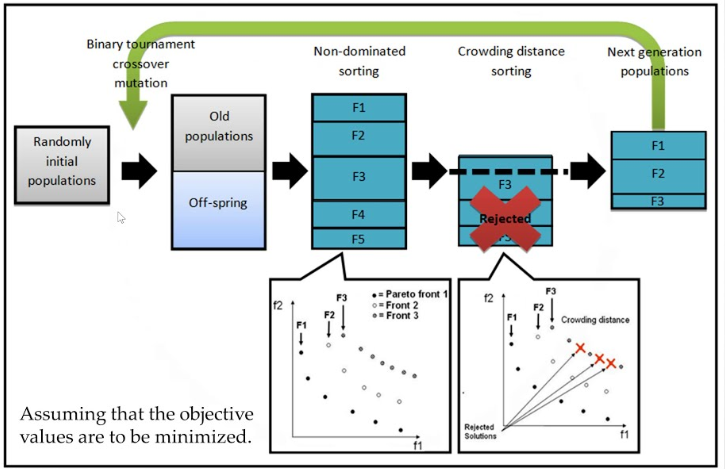

## Usando o NSGA-II na prática

Vamos retormar ao exemplo que usamos anteriormente em que temos o problema abaixo:

$\min_{x,y} f_1(x,y) = \frac{x^2}{4} + \frac{y^2}{2} + 2x -3y \\
 \min_{x,y} f_2(x,y) = \frac{x^2}{2} + y^2 - 2x +6y$

O gráfico de contorno abaixo mostra as duas funções ($f_1$ em azul e $f_2$ em verde) e mostra ainda em vermelho uma linha tracejada ligando os pontos de ótimo das funções e indicando o conjunto de soluções pareto ótimas.

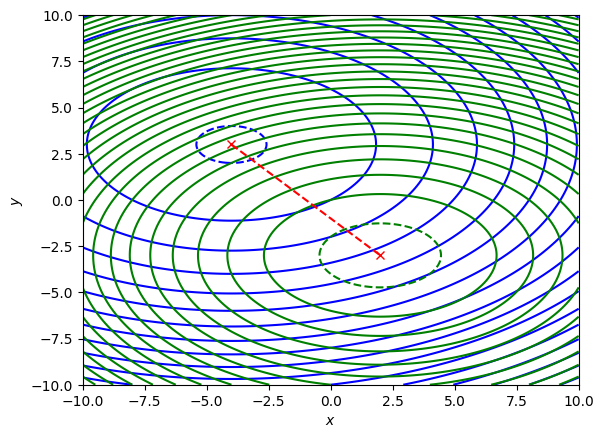

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = 1000
x = np.linspace(-10, 10, n)
y = np.linspace(-10, 10, n)
xv, yv = np.meshgrid(x, y)
f1 = xv**2/4 + yv**2/2 + 2*xv -3*yv
f2 = xv**2/2 + yv**2 - 2*xv + 6*yv

plt.contour(x,y,f1,levels=20,colors="blue")
plt.contour(x,y,f2,levels=30,colors="green")

#y = -x - 1
plt.plot(-4,3,'x',color="red")
plt.plot(2,-3,'x',color="red")
plt.plot([-4,2],[3,-3],'--',color="red")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Abaixo nós resolvemos o problema com a biblioteca ```pymoo```.

Começamos estabelecendo o problema multiobjetivo na classe ```Exemplo``` que herda da classe ```Problem```. No construtor indicamos que o problem tem duas  variáveis de decisão (```n_var = 2```), dois objetivos (```n_obj = 2```) e que não possui restrições (```n_constr = 0```). Além disso, especificamos os limites inferior ```xl``` e superior ```xu``` de cada variável, sendo que os valores da lista são usados na ordem portanto, neste caso, temos que $-100 \leq x,y \leq 100$.

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import  SBX
import matplotlib.pyplot as plt


class Exemplo(Problem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=[-100,-100], xu=[100,100])

    def _evaluate(self, x, out, *args, **kwargs):
        xv = x[:,0]
        yv = x[:,1]
        f1 = np.power(xv,2)/4 + np.power(yv,2)/2 + 2*xv - 3*yv
        f2 = np.power(xv,2)/2 + np.power(yv,2) - 2*xv + 6*yv
        out["F"] = np.column_stack((f1,f2))

problem = Exemplo()

algorithm = NSGA2(pop_size=50,
                  mutation=PolynomialMutation(prob=0.5, eta=20),
                  crossover=SBX(prob=1.0, prob_var=0.5, eta=20))

res = minimize(problem,
               algorithm,
               ('n_gen', 3),
               save_history=True,
               seed=1)

### Fronteira de Pareto

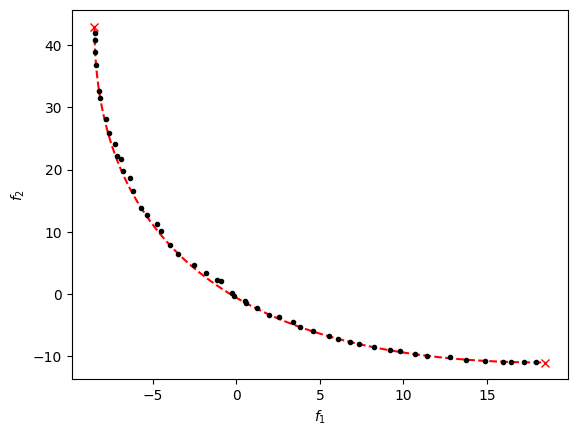

In [ ]:
n = 1000
x = np.linspace(-4, 2, n)
y = -x-1

def f1(x,y):
  return x**2/4 + y**2/2 + 2*x -3*y

def f2(x,y):
  return x**2/2 + y**2 - 2*x + 6*y

plt.plot(f1(x,y),f2(x,y),"--",color="red")
plt.plot(f1(-4,3),f2(-4,3),'x',color="red")
plt.plot(f1(2,-3),f2(2,-3),'x',color="red")

f1 =res.F[:,0]
f2 = res.F[:,1]
plt.plot(f1,f2,'.',color="black")

plt.xlabel("$f_1$")
plt.ylabel("$f_2$")
plt.show()

### Soluções pareto ótimas

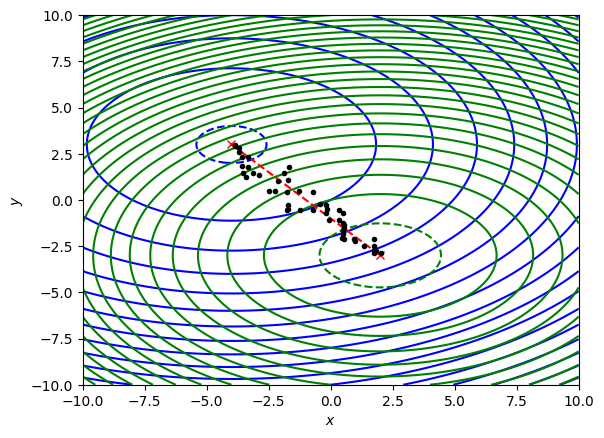

In [ ]:
n = 1000
x = np.linspace(-10, 10, n)
y = np.linspace(-10, 10, n)
xv, yv = np.meshgrid(x, y)
f1 = xv**2/4 + yv**2/2 + 2*xv -3*yv
f2 = xv**2/2 + yv**2 - 2*xv + 6*yv

plt.contour(x,y,f1,levels=20,colors="blue")
plt.contour(x,y,f2,levels=30,colors="green")

#y = -x - 1
plt.plot(-4,3,'x',color="red")
plt.plot(2,-3,'x',color="red")
plt.plot([-4,2],[3,-3],'--',color="red")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(res.X[:,0],res.X[:,1],'.',color="black")
plt.show()

### Evolução das soluções

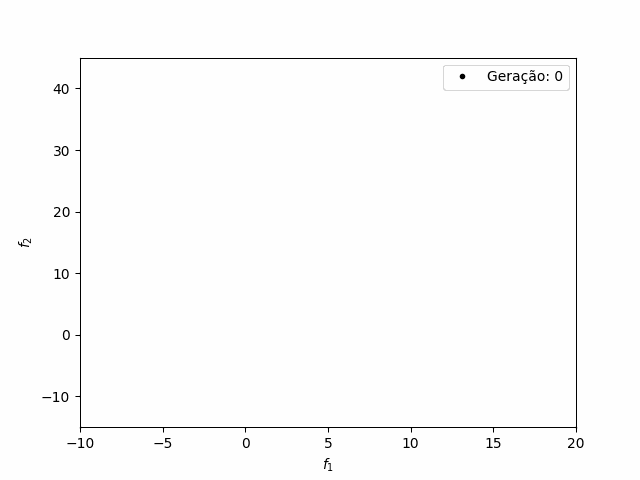

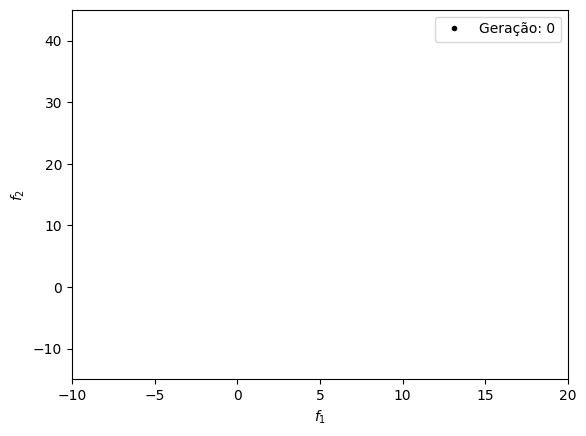

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image

fig, ax = plt.subplots()
a = res.history[0]
b = a.result()

scat = ax.plot(b.F[:,0],b.F[:,1],'.',color="black",label="Geração: 0")[0]
ax.set(xlim=[-10, 20], ylim=[-15, 45], xlabel='$f_1$', ylabel='$f_2$')
L = ax.legend()

def update(frame):
    # for each frame, update the data stored on each artist.
    a = res.history[frame]
    b = a.result()
    x = b.F[:,0]
    y = b.F[:,1]
    # update the scatter plot:
    scat.set_xdata(x)
    scat.set_ydata(y)
    L.get_texts()[0].set_text("Geração: "+str(frame))
    return scat #(scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=50, interval=60)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=2, bitrate=1800)
ani.save('scatter.gif', writer=writer)
Image(open('scatter.gif','rb').read())

## Críticas

Criado há cerca de 20 anos, o NSGA-II pode ser dito como a metahueristica padrão para solução de problemas de otimização multiobjetivo (NEBRO et al., 2022). Novas técnicas são em geral comparadas com o NSGA-II e esta é, geralmente, a primeira escolha para solução de problemas deste tipo no mundo real.

Deve-se destacar que o NSGA-II tem uma conhecida limitação em convergir ao lidar com problemas com muitos objetivos (KöPPEN, M.; VICENTE-GARCIA, R.; NICKOLAY, B., 2006), os quais são chamados de ***many-objective problems*** em contraposição aos *multi-objective problems*. Tais problema com muitos objetivos podem ter 3, 4 ou mais objetivos, podendo chegar à dezenas de objetivos.

Embora a mecânica de funcionamento do NSGA-II não o impeça de trabalhar com mais objetivos, sabe-se que ele tem dificuldades em manter uma população diversa já nas primeiras interações do algoritmo. A principal causa disso, como mostram (KöPPEN, M.; VICENTE-GARCIA, R.; NICKOLAY, B., 2006), é que <u>a probabilidade de termos soluções não-dominadas já no sorteio inicial das soluções aumenta com o número de funções objetivos</u>.



Mostramos este resultado experimentalmente abaixo.

Com base no problema padronizado DTLZ2 com 15 variáveis e um número variável de funções objetivos (de 2 a 30 funções), fazemos apenas a primeira iteração do NSGA-II, com uma população de 100 cromossomos, e medimos o número de soluções não-dominadas. Repetimos este experimento 100 vezes.

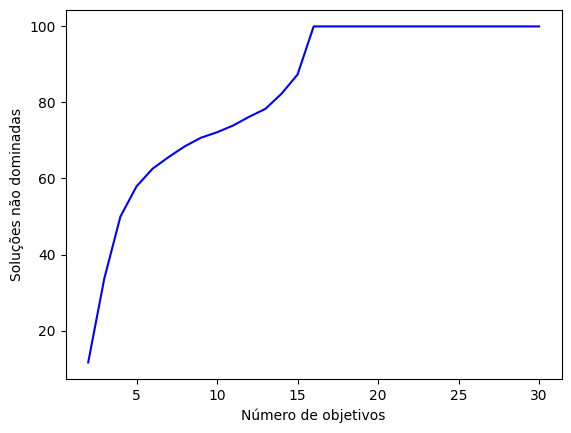

In [ ]:
import numpy as np
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import  SBX
import matplotlib.pyplot as plt

rank1 = []
obj_exp = range(2,31)

for objs in obj_exp:
  media = []
  for i in range(100):
    problem = get_problem("DTLZ2", n_var=15, n_obj = objs)
    algorithm = NSGA2(pop_size=100)
    res = minimize(problem,
                  algorithm,
                  ('n_gen', 1),
                  seed=i)
    media.append(len(res.F))
  rank1.append(np.mean(media))

plt.plot(obj_exp,rank1,color="blue")

plt.xlabel("Número de objetivos")
plt.ylabel("Soluções não dominadas")
plt.show()

O experimento para 2 a 5 objetivos, a quantidade de soluções não-dominadas cresce rapidamente. Além disso, para uma quantidade grande de objetivos, praticamente todas as soluções geradas inicialmente são não-dominadas. Isso faz com que o operador de dominância ciente de aglomeração trabalhe apenas com o isolamento, o qual, em uma população inicial, é bastante aleatório fazendo com que o algoritmo não caminhe para convergência, tornando-se quase como uma busca aleatória.

Diversas propostas (várias implementadas na biblioteca ```pymoo```) tentam modificar o NSGA-II para obter uma seleção inicial melhor. Esta é inclusive uma das motivações da proposição do NSGA-III, proposto pelos autores originais do NSGA-II (DEB & JAIN, 2013).

# Referências

DEB, K.; AGRAWAL, R. B. [**Simulated binary crossover for continuous search space**](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d3c8dca5e1629dbd7bef6c6ef0187820802437d5). Complex systems, 9(2):115-48, 1995.

DEB, K.; JAIN, H., **An evolutionary many-objective optimization algorithm using reference-point-based nondominated sorting approach, part I: solving problems with box constraints**. IEEE transactions on evolutionary computation, 18(4), pp.577-601, 2013.

DEB, K.; PRATAP, A.; AGARWAL, S.; MEYARIVAN, T. [**A fast and elitist multiobjective genetic algorithm: Nsga-ii**](https://cs.uwlax.edu/~dmathias/cs419/readings/NSGAIIElitistMultiobjectiveGA.pdf). IEEE transactions on evolutionary computation, IEEE, v. 6, n. 2, p. 182–197, 2002.

DEB, K.; SINDHYA, K.; OKABE, T. [**Self-adaptive simulated binary crossover for real-parameter optimization**](https://core.ac.uk/download/pdf/291575195.pdf), 9th Annual Conference on Genetic and Evolutionary Computation, 1187–1194. New York, NY, USA, 2007.

DOBNIKAR, A.; STEELE, N.C.; PEARSON, D.W.; ALBRECHT, R.F.; DEB, K.; AGRAWAL, S., 1999. [**A niched-penalty approach for constraint handling in genetic algorithms**](https://web.archive.org/web/20051205012724id_/http://vision.ucsd.edu:80/~sagarwal/icannga.pdf). Proceedings of the International Conference in Portorož, Slovenia,  Springer Vienna, pp. 235-243, 1999.

GOLDBERG, D. E.; HOLLAND, J. H. **Genetic algorithms and machine learning**. Machine learning, Springer, v. 3, n. 2, p. 95–99, 1988.

KöPPEN, M.; VICENTE-GARCIA, R.; NICKOLAY, B. **Fuzzy-pareto-dominance and its application in evolutionary multi-objective optimization**.International conference on evolutionary multi-criterion optimization, pp. 399-412, 2005.

NEBRO, A.J.; GALEANO-BRAJONES, J.; LUNA, F.; COELLO COELLO, C.A. **Is NSGA-II Ready for Large-Scale Multi-Objective Optimization?**. Mathematical and Computational Applications, 27(6), p.103,  2022.

SRINIVAS, N.; DEB, K. **Multiobjective optimization using nondominated sorting in genetic algorithms**. Evolutionary computation, MIT Press, v. 2, n. 3, p. 221–248, 1994.